In [1]:
import pandas as pd
import numpy as np
from skimage.util import invert, random_noise
import tensorflow as tf
from tensorflow.keras import layers, models, utils, optimizers
import matplotlib.pyplot as plt

In [22]:
labels = {0: 'T-shirt/top', 1: 'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Coat',
          5: 'Sandal',      6: 'Shirt',   7: 'Sneaker',  8: 'Bag',   9: 'Ankle Boot'}

In [103]:
def augment(train, test):
    """Generate more training data by creating different sized images."""
    new_train = train
    new_test = test
    scales = [21, 18]
    for scale in scales:
        new = tf.image.resize(train, [scale, scale])
        new = tf.image.resize_with_crop_or_pad(new, 28, 28)
        new_train = np.append(new_train, new, axis = 0)
        new_test = np.append(new_test, test, axis = 0)

    new_train = np.append(new_train, np.flip(new_train, axis=2), axis = 0)
    new_test = np.append(new_test, new_test, axis = 0)

    return new_train, new_test

In [40]:
train = pd.read_csv('data/fashion-mnist_train.csv')
test = pd.read_csv('data/fashion-mnist_test.csv')

In [104]:
X_train = np.array(train.drop(columns=['label'])) / 255
X_test = np.array(test.drop(columns=['label'])) / 255

y_train = np.array(train['label'])
y_test = np.array(test['label'])

X_train = np.reshape(X_train, (X_train.shape[0], 28,28, 1))
X_test = np.reshape(X_test, (X_test.shape[0], 28,28, 1))

y_train = utils.to_categorical(y_train)
y_test = utils.to_categorical(y_test)

In [106]:
X_train, y_train = augment(X_train, y_train)
X_test, y_test = augment(X_test, y_test)

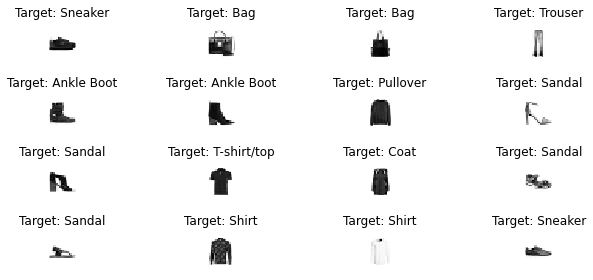

In [108]:
rows = 4
columns = 4
fig, axs = plt.subplots(rows,columns, figsize=(10, 4))
indx = -1
for i in range(rows):
    for j in range(columns):
        axs[i,j].imshow(X_train[indx], interpolation='nearest', cmap='Greys')
        axs[i,j].axis('off')
        axs[i,j].autoscale(False)
        axs[i,j].title.set_text(f'Target: {labels[y_train[indx].argmax()]}')
        indx -= 1
plt.tight_layout()
plt.show()

In [109]:
model = models.Sequential()

model.add(layers.Conv2D(32, 3, activation='relu', input_shape=(28,28, 1)))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))


model.add(layers.Conv2D(64, 3, activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.3))
model.add(layers.BatchNormalization())

model.add(layers.Conv2D(128, 3, activation='relu'))
model.add(layers.Conv2D(128, 3, activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(layers.Dropout(0.4))

model.add(layers.Flatten())
model.add(layers.BatchNormalization())

model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(10, activation='softmax'))

optimizer = optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [110]:
history = model.fit(X_train, y_train, epochs=5,
                    batch_size = 128,
                    validation_data=(X_test, y_test))

Epoch 1/5
2813/2813 [==============================] - 376s 133ms/step - loss: 0.4452 - accuracy: 0.8358 - val_loss: 0.2767 - val_accuracy: 0.8978
Epoch 2/5
2813/2813 [==============================] - 390s 139ms/step - loss: 0.3158 - accuracy: 0.8842 - val_loss: 0.2688 - val_accuracy: 0.8993
Epoch 3/5
2813/2813 [==============================] - 394s 140ms/step - loss: 0.2835 - accuracy: 0.8968 - val_loss: 0.2358 - val_accuracy: 0.9097
Epoch 4/5
2813/2813 [==============================] - 354s 126ms/step - loss: 0.2646 - accuracy: 0.9033 - val_loss: 0.2351 - val_accuracy: 0.9122
Epoch 5/5
2813/2813 [==============================] - 362s 129ms/step - loss: 0.2523 - accuracy: 0.9078 - val_loss: 0.2197 - val_accuracy: 0.9191


Pullover


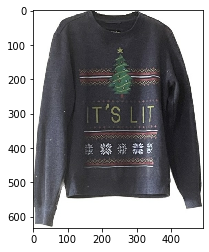

T-shirt/top: 0.36%
Trouser: 0.02%
Pullover: 47.66%
Dress: 0.06%
Coat: 11.08%
Sandal: 0.0%
Shirt: 40.79%
Sneaker: 0.0%
Bag: 0.03%
Ankle Boot: 0.0%


In [112]:
img = tf.io.read_file('data/pullover.jpg')
img = tf.image.decode_jpeg(img) / 255
plt.imshow(img, interpolation='nearest', cmap='Greys')
img = tf.image.rgb_to_grayscale(img)
img = invert(np.array(img))
img = tf.image.resize_with_pad(img, 28, 28)

img = np.reshape(img, (1,28,28,1))
pred = model.predict(img)[0]

print(labels[pred.argmax()])
plt.show()
for i, confidence in enumerate(pred):
    print('{}: {}%'.format(labels[i], round(confidence*100,2)))

Ankle Boot


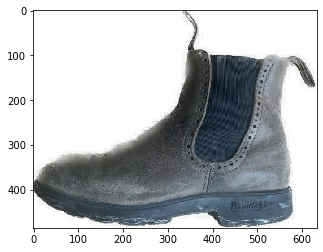

T-shirt/top: 0.0%
Trouser: 0.0%
Pullover: 0.0%
Dress: 0.0%
Coat: 0.0%
Sandal: 0.0%
Shirt: 0.0%
Sneaker: 0.69%
Bag: 0.0%
Ankle Boot: 99.31%


In [113]:
img = tf.io.read_file('data/boot.jpg')
img = tf.image.decode_jpeg(img) / 255
plt.imshow(img, interpolation='nearest', cmap='Greys')
img = tf.image.rgb_to_grayscale(img)
img = invert(np.array(img))
img = tf.image.resize_with_pad(img, 28, 28)

img = np.reshape(img, (1,28,28,1))
pred = model.predict(img)[0]

print(labels[pred.argmax()])
plt.show()
for i, confidence in enumerate(pred):
    print('{}: {}%'.format(labels[i], round(confidence*100,2)))

In [7]:
model.save('model')
converter =tf.lite.TFLiteConverter.from_saved_model('model')
tflite_model = converter.convert()

with open('../Backend/model.tflite', 'wb') as f:
    f.write(tflite_model)